In [9]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# PyTorch용 증강 라이브러리
import torchvision.transforms as T

# sklearn for stratified split
from sklearn.model_selection import train_test_split

In [10]:
RAW_TRAIN="../../data/raw/T_image_data"
RAW_VAL="../../data/raw/V_image_data"
SAVE_DIR="../../data/processed/04_processed_data"
os.makedirs(f"{SAVE_DIR}/images", exist_ok=True)

SEED=42
random.seed(SEED)
np.random.seed(SEED)

In [11]:
# 성별 매핑
sex_Male_list=["GF", "F", "S", "S1", "S2", "S3", "S4"]
sex_Female_list=["GM", "M", "D", "D1", "D2", "D3", "D4"]

In [12]:
all_labels=[]

def age_to_group(age):
    if age < 10:
        return "0s"
    elif age < 20:
        return "10s"
    elif age < 30:
        return "20s"
    elif age < 40:
        return "30s"
    elif age < 50:
        return "40s"
    elif age < 60:
        return "50s"
    else:
        return "60+"

def process_folder(folder):
    for file in os.listdir(folder):
        if not (file.endswith(".jpg") or file.endswith(".JPG")):
            continue

        parts=file.split("_")
        gender_code=parts[2]
        age=int(parts[3])

        if gender_code in sex_Male_list:
            gender="male"
        elif gender_code in sex_Female_list:
            gender="female"
        else:
            continue

        age_group=age_to_group(age)

        all_labels.append({
            "filename":file,
            "gender":gender,
            "age_group":age_group,
            "folder":folder
        })

process_folder(RAW_TRAIN)
process_folder(RAW_VAL)

labels_df=pd.DataFrame(all_labels)
print(f"총 {len(labels_df)}장 수집 완료")
labels_df.head()

총 9520장 수집 완료


,filename,gender,age_group,folder
0,F0204_IND_D_15_0_03.JPG,female,10s,../../data/raw/T_image_data
1,F0465_IND_D_12_0_02.JPG,female,10s,../../data/raw/T_image_data
2,F0039_IND_D_14_0_04.JPG,female,10s,../../data/raw/T_image_data
3,F0239_IND_F_47_0_01.JPG,male,40s,../../data/raw/T_image_data
4,F0304_IND_M_48_0_05.JPG,female,40s,../../data/raw/T_image_data


group
female_10s    1844
male_10s      1792
female_40s    1072
female_60+     833
female_20s     701
male_40s       676
male_50s       544
male_20s       536
female_50s     521
male_60+       448
female_30s     265
male_30s       168
female_0s       60
male_0s         60
Name: count, dtype: int64


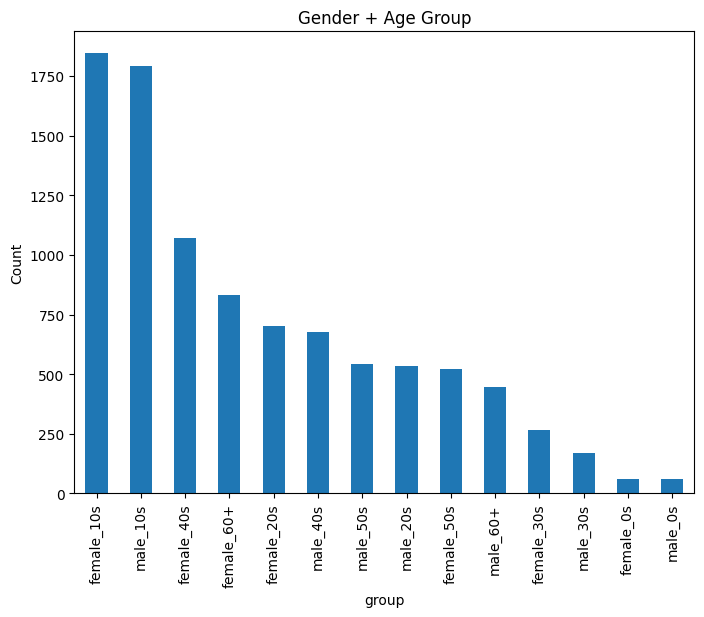

In [13]:
labels_df["group"]=labels_df["gender"] + "_" + labels_df["age_group"]

group_counts=labels_df["group"].value_counts()
print(group_counts)

plt.figure(figsize=(8, 6))
group_counts.plot(kind="bar")
plt.title("Gender + Age Group")
plt.ylabel("Count")
plt.show()

In [14]:
target_count=group_counts.max()
print(f"각 그룹을 {target_count}장으로 맞춤")

transform=T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(15),
    T.ToTensor()
])

augmented_labels=[]

for group_name, count in tqdm(group_counts.items()):
    need_count=target_count - count
    if need_count <= 0:
        continue

    group_df=labels_df[labels_df["group"]==group_name]

    for i in range(need_count):
        row=group_df.sample(1, random_state=SEED+i).iloc[0]

        img_path=os.path.join(row["folder"], row["filename"])
        img=Image.open(img_path).convert("RGB")

        aug_img=transform(img)
        aug_img=T.ToPILImage()(aug_img)

        save_name=f"AUG_{group_name}_{i}_{row['filename']}"
        aug_img.save(f"{SAVE_DIR}/images/{save_name}")

        augmented_labels.append({
            "filename":save_name,
            "gender":row["gender"],
            "age_group":row["age_group"],
            "folder":f"{SAVE_DIR}/images",
            "group":group_name
        })

print(f"증강 이미지 {len(augmented_labels)}장 생성 완료")

각 그룹을 1844장으로 맞춤


14it [1:08:01, 291.52s/it]

증강 이미지 16296장 생성 완료


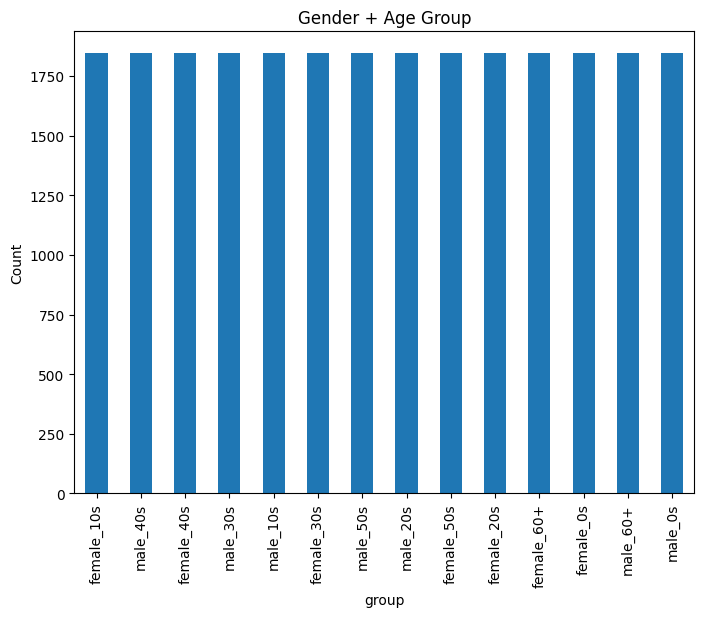

In [15]:
aug_df=pd.DataFrame(augmented_labels)
total_df=pd.concat([labels_df, aug_df], ignore_index=True)

total_counts=total_df["group"].value_counts()

plt.figure(figsize=(8, 6))
total_counts.plot(kind="bar")
plt.title("Gender + Age Group")
plt.ylabel("Count")
plt.show()

In [16]:
multi_labels=[]

for _, row in tqdm(total_df.iterrows(), total=len(total_df)):
    src=os.path.join(row["folder"], row["filename"])
    dst=os.path.join(SAVE_DIR, "images", row["filename"])

    if not os.path.exists(dst):
        Image.open(src).save(dst)

    male=1 if row["gender"]=="male" else 0
    female=1 if row["gender"]=="female" else 0

    age_labels={"0s":0, "10s":0, "20s":0, "30s":0, "40s":0, "50s":0, "60+":0}
    age_labels[row["age_group"]]=1

    multi_labels.append({
        "filename":row["filename"],
        "male":male,
        "female":female,
        **age_labels
    })

final_labels=pd.DataFrame(multi_labels)
final_labels.to_csv(f"{SAVE_DIR}/all_labels.csv", index=False)
print(f"최종 라벨 CSV 저장 완료 ({len(final_labels)}장)")

  0%|          | 0/25816 [00:00<?, ?it/s]

100%|██████████| 25816/25816 [09:50<00:00, 43.72it/s]   


최종 라벨 CSV 저장 완료 (25816장)


In [17]:
final_labels["stratify_col"]=final_labels.apply(
    lambda row: f"{row['male']}_{[col for col in ['0s','10s','20s','30s','40s','50s','60+'] if row[col]==1][0]}", axis=1
)

train_df, val_df=train_test_split(final_labels, test_size=0.2, stratify=final_labels["stratify_col"], random_state=SEED)

train_df.to_csv(f"{SAVE_DIR}/train_labels.csv", index=False)
val_df.to_csv(f"{SAVE_DIR}/val_labels.csv", index=False)

print(f"Train: {len(train_df)}개, Val: {len(val_df)}개 저장 완료")

Train: 20652개, Val: 5164개 저장 완료
